In [68]:
%reload_ext autoreload
%autoreload 2

In [69]:
import sys
sys.path.append('..')

In [70]:
# sub_folder = 'init'
sub_folder = 'pretrain'

## Dataset

In [71]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [72]:
from src.infra.registry import DATASET_REGISTRY
DATASET_REGISTRY

{'Dataset': torch.utils.data.dataset.Dataset,
 'SingleFaustDataset': src.dataset.shape_cor.SingleFaustDataset,
 'SingleScapeDataset': src.dataset.shape_cor.SingleScapeDataset,
 'SingleShrec19Dataset': src.dataset.shape_cor.SingleShrec19Dataset,
 'SingleSmalDataset': src.dataset.shape_cor.SingleSmalDataset,
 'SingleDT4DDataset': src.dataset.shape_cor.SingleDT4DDataset,
 'SingleShrec20Dataset': src.dataset.shape_cor.SingleShrec20Dataset,
 'SingleTopKidsDataset': src.dataset.shape_cor.SingleTopKidsDataset,
 'PairDataset': src.dataset.shape_cor.PairDataset,
 'PairFaustDataset': src.dataset.shape_cor.PairFaustDataset,
 'PairScapeDataset': src.dataset.shape_cor.PairScapeDataset,
 'PairShrec19Dataset': src.dataset.shape_cor.PairShrec19Dataset,
 'PairSmalDataset': src.dataset.shape_cor.PairSmalDataset,
 'PairDT4DDataset': src.dataset.shape_cor.PairDT4DDataset,
 'PairShrec20Dataset': src.dataset.shape_cor.PairShrec20Dataset,
 'PairShrec16Dataset': src.dataset.shape_cor.PairShrec16Dataset,
 'Pai

In [73]:
from src.utils.tensor import to_device

dataset = DATASET_REGISTRY['PairFaustDataset'](
    phase='train',
    data_root='../data/FAUST_r/',
    return_evecs='true',
    return_faces='true',
    num_evecs=200,
    return_corr='false',
    return_dist='false',
)

In [74]:
# sample
data = dataset[1]
data_x, data_y = to_device(data['first'], device), to_device(data['second'], device)
data_x['name'], data_y['name']

('tr_reg_000', 'tr_reg_001')

## Model components

### DiffusionNet feature extractor

In [75]:
import src
from src.infra.registry import MODEL_REGISTRY
MODEL_REGISTRY

{'Similarity': src.model.permutation.Similarity,
 'RegularizedFMNet': src.model.fmap.RegularizedFMNet,
 'DiffusionNet': src.model.diffusionnet.DiffusionNet}

In [76]:
feature_extractor = MODEL_REGISTRY['DiffusionNet'](
    in_channels=128,
    out_channels=256,
    cache_dir='../data/FAUST_r/diffusion',
    input_type='wks',
).to(device)
feature_extractor

DiffusionNet(
  (first_linear): Linear(in_features=128, out_features=128, bias=True)
  (last_linear): Linear(in_features=128, out_features=256, bias=True)
  (blocks): ModuleList(
    (0): DiffusionNetBlock(
      (diffusion): LearnedTimeDiffusion()
      (gradient_features): SpatialGradientFeatures(
        (A_re): Linear(in_features=128, out_features=128, bias=False)
        (A_im): Linear(in_features=128, out_features=128, bias=False)
      )
      (mlp): MiniMLP(
        (miniMLP_linear_000): Linear(in_features=384, out_features=128, bias=True)
        (miniMLP_activation_000): ReLU()
        (miniMLP_dropout_001): Dropout(p=0.5, inplace=False)
        (miniMLP_linear_001): Linear(in_features=128, out_features=128, bias=True)
        (miniMLP_activation_001): ReLU()
        (miniMLP_dropout_002): Dropout(p=0.5, inplace=False)
        (miniMLP_linear_002): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): DiffusionNetBlock(
      (diffusion): LearnedTimeDiff

In [77]:
# load pretrain weights
network_path = '../checkpoints/faust.pth'
feature_extractor.load_state_dict(
    torch.load(network_path)['networks']['feature_extractor']
)
feature_extractor

DiffusionNet(
  (first_linear): Linear(in_features=128, out_features=128, bias=True)
  (last_linear): Linear(in_features=128, out_features=256, bias=True)
  (blocks): ModuleList(
    (0): DiffusionNetBlock(
      (diffusion): LearnedTimeDiffusion()
      (gradient_features): SpatialGradientFeatures(
        (A_re): Linear(in_features=128, out_features=128, bias=False)
        (A_im): Linear(in_features=128, out_features=128, bias=False)
      )
      (mlp): MiniMLP(
        (miniMLP_linear_000): Linear(in_features=384, out_features=128, bias=True)
        (miniMLP_activation_000): ReLU()
        (miniMLP_dropout_001): Dropout(p=0.5, inplace=False)
        (miniMLP_linear_001): Linear(in_features=128, out_features=128, bias=True)
        (miniMLP_activation_001): ReLU()
        (miniMLP_dropout_002): Dropout(p=0.5, inplace=False)
        (miniMLP_linear_002): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): DiffusionNetBlock(
      (diffusion): LearnedTimeDiff

In [78]:
feat_x = feature_extractor(
    data_x['verts'].unsqueeze(0),
    data_x['faces'].unsqueeze(0),
)

feat_y = feature_extractor(
    data_y['verts'].unsqueeze(0),
    data_y['faces'].unsqueeze(0),
)

feat_x.shape, feat_y.shape

(torch.Size([1, 4999, 256]), torch.Size([1, 5000, 256]))

In [79]:
# compare features computed from mesh and point cloud
feat_x_pcd = feature_extractor(
    data_x['verts'].unsqueeze(0),
    # data_x['faces'].unsqueeze(0),
)

(feat_x - feat_x_pcd).abs().mean()

tensor(1.4807, device='cuda:0', grad_fn=<MeanBackward0>)

### Funtional maps solver

In [80]:
fm_solver = MODEL_REGISTRY['RegularizedFMNet'](
    bidirectional=True,
).to(device)

fm_solver

RegularizedFMNet()

In [81]:
evals_x = data_x['evals']
evals_y = data_y['evals']
evecs_x = data_x['evecs']
evecs_y = data_y['evecs']
evecs_trans_x = data_x['evecs_trans']
evecs_trans_y = data_y['evecs_trans']

#### Eigen vectors

In [82]:
evecs_x.shape, evecs_trans_x.shape

(torch.Size([4999, 200]), torch.Size([200, 4999]))

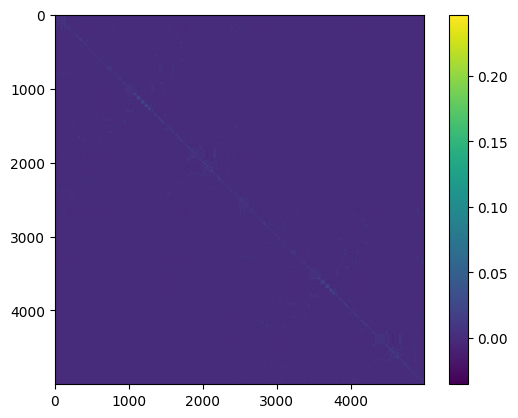

In [83]:
# verify eigen vectors' inverses
import matplotlib.pyplot as plt
from src.utils.tensor import to_numpy

plt.imshow(to_numpy(evecs_x @ evecs_trans_x))
plt.colorbar()
plt.show()

#### Functional maps

In [84]:
Cxy, Cyx = fm_solver(
    feat_x, feat_y,
    evals_x.unsqueeze(0),
    evals_y.unsqueeze(0),
    evecs_trans_x.unsqueeze(0),
    evecs_trans_y.unsqueeze(0),
)

Cxy.shape, Cyx.shape

(torch.Size([1, 200, 200]), torch.Size([1, 200, 200]))

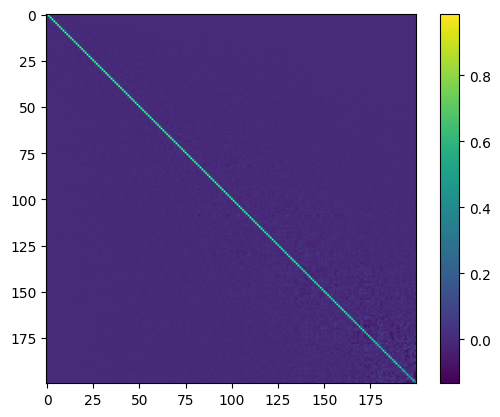

In [85]:
# verify inverse maps

plt.imshow(to_numpy((Cxy @ Cyx)[0]))
plt.colorbar()
plt.show()

### Point-wise correspondence matrix

In [86]:
permutation = MODEL_REGISTRY['Similarity'](
    tau=0.07,
)

In [87]:
import torch.nn.functional as F

feat_x = F.normalize(feat_x, dim=-1, p=2)
feat_y = F.normalize(feat_y, dim=-1, p=2)
similarity = torch.bmm(feat_x, feat_y.transpose(1, 2))

# sinkhorn normalization
Pxy = permutation(similarity)
Pyx = permutation(similarity.transpose(1, 2))

Pxy.shape, Pyx.shape

(torch.Size([1, 4999, 5000]), torch.Size([1, 5000, 4999]))

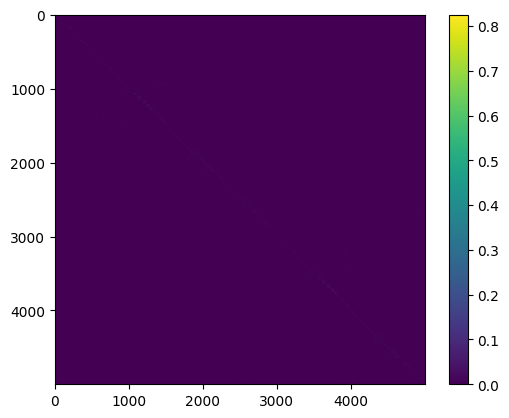

In [88]:
plt.imshow(to_numpy(Pxy))
plt.colorbar()
plt.show()

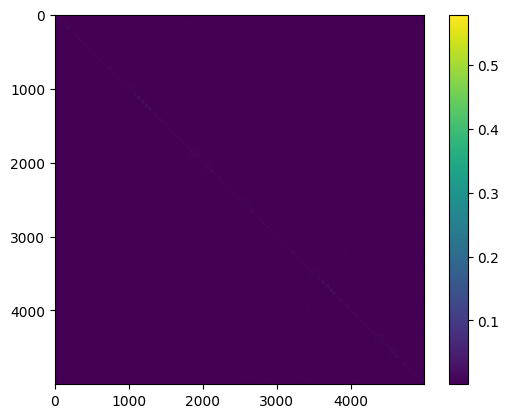

In [89]:
plt.imshow(to_numpy(Pxy @ Pyx))
plt.colorbar()
plt.show()

## Loss

In [90]:
from src.infra.registry import LOSS_REGISTRY
LOSS_REGISTRY

{'MSELoss': torch.nn.modules.loss.MSELoss,
 'SquaredFrobeniusLoss': src.loss.fmap.SquaredFrobeniusLoss,
 'SURFMNetLoss': src.loss.fmap.SURFMNetLoss,
 'PartialFmapsLoss': src.loss.fmap.PartialFmapsLoss,
 'DirichletLoss': src.loss.dirichlet.DirichletLoss}

In [91]:
surfm_loss = LOSS_REGISTRY['SURFMNetLoss'](
    w_bij=1.0,
    w_orth=1.0,
    w_lap=0.0,
)
surfm_loss(Cxy, Cyx, evals_x, evals_y)

{'l_bij': tensor(14.5374, device='cuda:0', grad_fn=<MulBackward0>),
 'l_orth': tensor(42.8099, device='cuda:0', grad_fn=<MulBackward0>)}

In [92]:
align_loss = LOSS_REGISTRY['SquaredFrobeniusLoss'](
    loss_weight=1.0,
)

Cxy_est = torch.bmm(
    evecs_trans_y.unsqueeze(0),
    torch.bmm(Pyx, evecs_x.unsqueeze(0)),
)

Cyx_est = torch.bmm(
    evecs_trans_x.unsqueeze(0),
    torch.bmm(Pxy, evecs_y.unsqueeze(0)),
)

align_loss(Cxy, Cxy_est), align_loss(Cyx, Cyx_est)

(tensor(23.6075, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(25.7416, device='cuda:0', grad_fn=<MulBackward0>))

In [93]:
dirichlet_loss = LOSS_REGISTRY['DirichletLoss'](
    loss_weight=0.5,
)
Lx, Ly = data_x['L'], data_y['L']
dirichlet_loss(torch.bmm(Pxy, data_y['verts'].unsqueeze(0)), Lx.unsqueeze(0))

tensor(2.6047, device='cuda:0', grad_fn=<MulBackward0>)

## Metric

In [94]:
from src.infra.registry import METRIC_REGISTRY
METRIC_REGISTRY

{'L1Loss': torch.nn.modules.loss.L1Loss,
 'MSELoss': torch.nn.modules.loss.MSELoss,
 'MeanDiffRatio': src.metric.stats.MeanDiffRatio,
 'StdDiffRatio': src.metric.stats.StdDiffRatio,
 'calculate_geodesic_error': <function src.metric.geodist.calculate_geodesic_error(dist_x, corr_x, corr_y, p2p, return_mean=True)>,
 'plot_pck': <function src.metric.geodist.plot_pck(geo_err, threshold=0.1, steps=40)>}

In [95]:
from src.utils.fmap import fmap2pointmap

p2p = fmap2pointmap(Cxy.squeeze(), evecs_x, evecs_y)
p2p.shape

torch.Size([5000])

In [96]:
geo_err = METRIC_REGISTRY['calculate_geodesic_error'](
    dist_x=to_numpy(data_x['dist']),
    corr_x=to_numpy(data_x['corr']),
    corr_y=to_numpy(data_y['corr']),
    p2p=to_numpy(p2p),
    return_mean=False,
)
geo_err.shape, geo_err.mean()

((5000,), 0.014729806)

(0.8526897435897436,
 <Figure size 640x480 with 1 Axes>,
 array([0.3182, 0.3184, 0.329 , 0.3684, 0.412 , 0.4708, 0.5288, 0.6056,
        0.688 , 0.7508, 0.8068, 0.8458, 0.8748, 0.9032, 0.9244, 0.941 ,
        0.9548, 0.9626, 0.9696, 0.977 , 0.985 , 0.9936, 0.9954, 0.9972,
        0.9976, 0.9982, 0.9988, 0.9994, 0.9994, 0.9998, 0.9998, 0.9998,
        1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ]))

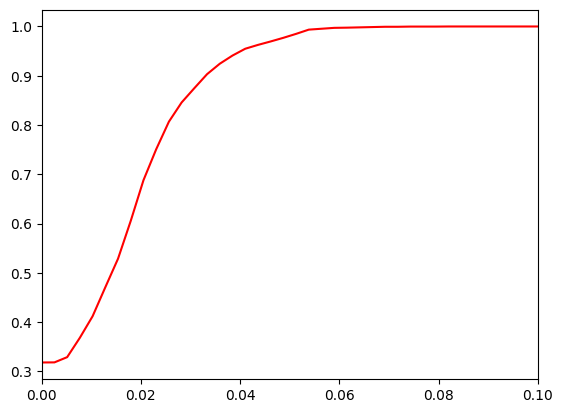

In [97]:
METRIC_REGISTRY['plot_pck'](geo_err)

## Visualization

In [99]:
import os
import shutil
from src.utils.texture import write_obj_pair

if os.path.isfile('output/texture.png'):
    shutil.copy('output/texture.png',
    os.path.join('output', 'init', 'texture.png'),
)

name_x, name_y = data_x['name'], data_y['name']
file_x = os.path.join('output', sub_folder, f'{name_x}.obj')
file_y = os.path.join('output', sub_folder, f'{name_x}-{name_y}.obj')
faces_x, faces_y = to_numpy(data_x['faces']), to_numpy(data_y['faces'])
verts_x, verts_y = to_numpy(data_x['verts']), to_numpy(data_y['verts'])

write_obj_pair(file_x, file_y, verts_x, faces_x, verts_y, faces_y, to_numpy(Pyx), 'texture.png')